[1] Import & Global Settings

In [ ]:
# 📦 필수 라이브러리 로드
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, f1_score
)
import matplotlib.pyplot as plt
import copy

[2] 데이터 로딩 함수 + Dataset 구성

In [ ]:
# 📂 데이터 로딩 및 전처리 함수
def load_data(file_path="/content/data.csv", batch_size=64):
    df = pd.read_csv(file_path)

    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(float)

    # 이진 타겟 형태로 보장 (추가 안전장치)
    if df['y'].dtype != 'int':
        df['y'] = df['y'].astype(int)

    # X, y 분리
    X = df.drop(columns=['y'])
    y = df['y']

    # ✅ float 변환 (혹시 object 타입 남은 경우 대비)
    X = X.astype(float)

    # Train/Val/Test 분할
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    # PyTorch Dataset 정의
    from torch.utils.data import Dataset, DataLoader

    class BankDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = torch.tensor(y.values, dtype=torch.float32)

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    # Dataloader 생성
    train_dataset = BankDataset(X_train_sub, y_train_sub)
    val_dataset   = BankDataset(X_val, y_val)
    test_dataset  = BankDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    input_dim = X.shape[1]
    return train_loader, val_loader, test_loader, input_dim

 [3] 모델 정의 함수

In [ ]:
# 🔧 MLPClassifier 모델 정의 함수
class MLPClassifier(nn.Module):
    def __init__(self, input_dim):
        super(MLPClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

[4] 훈련 함수, 평가 함수, 시각화 함수

In [ ]:
# 📈 Train 함수 정의
def train_model(model, train_loader, val_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device).view(-1, 1)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Validation Loss
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            preds = model(xb)
            loss = criterion(preds, yb)
            val_loss += loss.item()

    return total_loss / len(train_loader), val_loss / len(val_loader)

# 📊 Evaluation 함수
def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

# 📈 학습곡선 시각화
def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

# 📑 성능 출력 함수
def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

[5] 메인 실행 코드 (모델 훈련 및 평가)

[Epoch 1] Train Loss: 0.3222 | Val Loss: 0.2877
[Epoch 2] Train Loss: 0.2970 | Val Loss: 0.2830
[Epoch 3] Train Loss: 0.2924 | Val Loss: 0.2812
[Epoch 4] Train Loss: 0.2913 | Val Loss: 0.2811
[Epoch 5] Train Loss: 0.2890 | Val Loss: 0.2811
[Epoch 6] Train Loss: 0.2881 | Val Loss: 0.2812
[Epoch 7] Train Loss: 0.2878 | Val Loss: 0.2796
[Epoch 8] Train Loss: 0.2865 | Val Loss: 0.2783
[Epoch 9] Train Loss: 0.2857 | Val Loss: 0.2796
[Epoch 10] Train Loss: 0.2853 | Val Loss: 0.2792
[Epoch 11] Train Loss: 0.2853 | Val Loss: 0.2802
[Epoch 12] Train Loss: 0.2852 | Val Loss: 0.2791
[Epoch 13] Train Loss: 0.2832 | Val Loss: 0.2789
🛑 Early stopping triggered at epoch 13

✅ Best Model saved at epoch 8, Val Loss: 0.2783


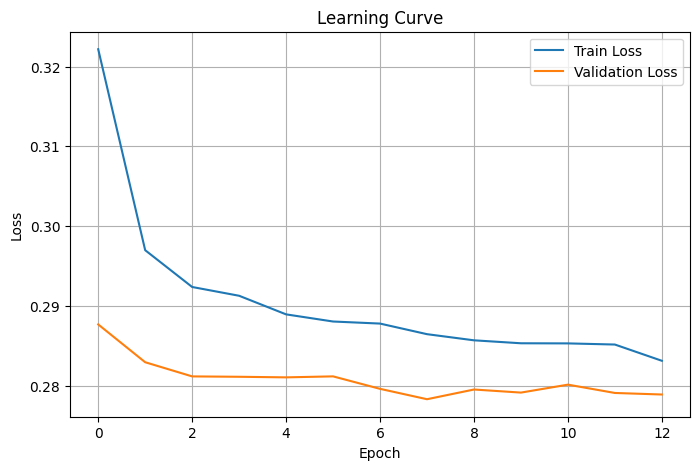

In [ ]:
# ⚙ 하이퍼파라미터 설정
num_epochs = 50
patience = 5
learning_rate = 0.001
batch_size = 64
model_path = "best_model.pth"

# 데이터 로딩
train_loader, val_loader, test_loader, input_dim = load_data(batch_size=batch_size)

# 모델/손실/옵티마이저 초기화
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLPClassifier(input_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# 학습 초기화
train_losses, val_losses = [], []
best_val_loss = float('inf')
best_epoch = 0
patience_counter = 0
best_weights = copy.deepcopy(model.state_dict())

# 모델 학습 (EarlyStopping 포함)
for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"[Epoch {epoch}] Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        best_weights = copy.deepcopy(model.state_dict())
        torch.save(model.state_dict(), model_path)
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"🛑 Early stopping triggered at epoch {epoch}")
            break

print(f"\n✅ Best Model saved at epoch {best_epoch}, Val Loss: {best_val_loss:.4f}")
plot_learning_curve(train_losses, val_losses)

[6] Best 모델 불러오기 및 최종 평가

In [ ]:
# ✅ Best 모델 로딩 및 테스트 평가
model.load_state_dict(torch.load(model_path))
y_true, y_prob = evaluate_model(model, test_loader, device)
y_pred = (y_prob >= 0.5).astype(int)
print_metrics(y_true, y_pred, y_prob)


📌 Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95      7310
         1.0       0.71      0.22      0.34       928

    accuracy                           0.90      8238
   macro avg       0.81      0.60      0.64      8238
weighted avg       0.89      0.90      0.88      8238

✅ Accuracy: 0.9020
✅ Precision: 0.7093
✅ Recall: 0.2209
✅ F1-score: 0.3369
✅ ROC AUC: 0.7996

📌 Confusion Matrix:
[[7226   84]
 [ 723  205]]


<ipython-input-6-beae9ad5eaf4>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


In [ ]:
###
# 귀찮
###

총 4 개의 조합을 테스트합니다.

실험 1/4: {'hidden_layers': [64, 32], 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamG', 'loss_fn': 'BCE', 'sampling': 'oversample', 'num_epochs': 30, 'patience': 5}
-> 검증 손실: 0.4989 (Best epoch: 3)

실험 2/4: {'hidden_layers': [64, 32], 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamG', 'loss_fn': 'BCE', 'sampling': 'undersample', 'num_epochs': 30, 'patience': 5}
-> 검증 손실: 0.4857 (Best epoch: 6)

실험 3/4: {'hidden_layers': [64, 32], 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamG', 'loss_fn': 'FocalLoss', 'sampling': 'oversample', 'num_epochs': 30, 'patience': 5}
-> 검증 손실: 0.1202 (Best epoch: 2)

실험 4/4: {'hidden_layers': [64, 32], 'dropout': 0.3, 'learning_rate': 0.001, 'batch_size': 32, 'optimizer': 'AdamG', 'loss_fn': 'FocalLoss', 'sampling': 'undersample', 'num_epochs': 30, 'patience': 5}
-> 검증 손실: 0.1274 (Best epoch: 15)

하이퍼파라미터 검색 완료. 총 시간: 78.93초

BCE with oversample sampling

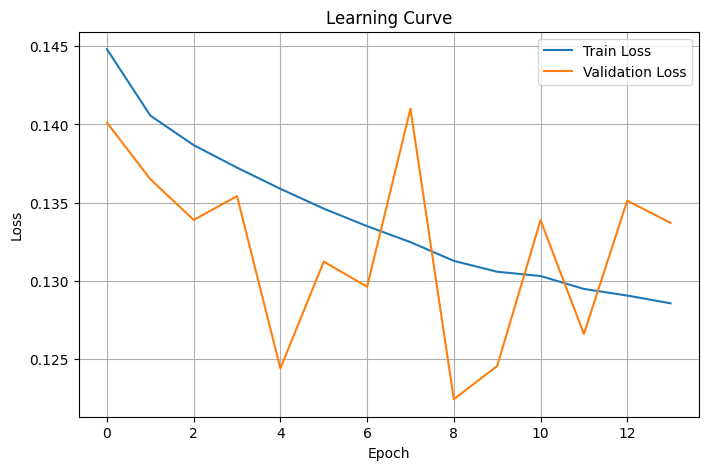


최종 테스트 결과:

📌 Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.86      0.91      7310
         1.0       0.38      0.64      0.47       928

    accuracy                           0.84      8238
   macro avg       0.66      0.75      0.69      8238
weighted avg       0.89      0.84      0.86      8238

✅ Accuracy: 0.8398
✅ Precision: 0.3763
✅ Recall: 0.6422
✅ F1-score: 0.4745
✅ ROC AUC: 0.7934

📌 Confusion Matrix:
[[6322  988]
 [ 332  596]]


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, classification_report, f1_score
)
import matplotlib.pyplot as plt
import copy
import itertools
import time

# imblearn을 통한 오버샘플링/언더샘플링
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

##############################################
# Focal Loss 구현
##############################################
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: raw logits, targets: 0/1 float tensor
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  # p_t
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

##############################################
# 1. 데이터 로딩 및 전처리 함수 + Dataset 구성
##############################################
def load_data(file_path="/content/data.csv", batch_size=64, sampling="none"):
    """
    데이터셋: 포르투갈 은행 마케팅 데이터
    - 총 인스턴스: 41,188개, 피처: 19개 + 타겟 y
    - sampling: "oversample", "undersample" 또는 "none" (기본값)
    """
    df = pd.read_csv(file_path)
    # bool 타입은 float로 변환
    for col in df.columns:
        if df[col].dtype == 'bool':
            df[col] = df[col].astype(float)
    # 타겟(y)이 정수형이 아닐 경우 변환
    if df['y'].dtype != 'int':
        df['y'] = df['y'].astype(int)
    # X, y 분리 및 float 변환
    X = df.drop(columns=['y'])
    y = df['y']
    X = X.astype(float)

    # Train/Test 분할 (stratify 옵션 사용)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=42
    )
    # Train/Validation 분할 (추가 검증 셋 확보)
    X_train_sub, X_val, y_train_sub, y_val = train_test_split(
        X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
    )

    # 오버샘플링 또는 언더샘플링 적용 (학습 데이터에만 적용)
    if sampling in ["oversample", "undersample"]:
        if sampling == "oversample":
            sampler = RandomOverSampler(random_state=42)
        else:  # undersample
            sampler = RandomUnderSampler(random_state=42)
        X_train_sub, y_train_sub = sampler.fit_resample(X_train_sub, y_train_sub)
        # resampled 결과를 DataFrame/Series로 복원 (열 이름 유지)
        X_train_sub = pd.DataFrame(X_train_sub, columns=X.columns)
        y_train_sub = pd.Series(y_train_sub)

    # PyTorch Dataset 클래스 정의
    class BankDataset(Dataset):
        def __init__(self, X, y):
            self.X = torch.tensor(X.values, dtype=torch.float32)
            self.y = torch.tensor(y.values, dtype=torch.float32)
        def __len__(self):
            return len(self.y)
        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    train_dataset = BankDataset(X_train_sub, y_train_sub)
    val_dataset = BankDataset(X_val, y_val)
    test_dataset = BankDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    input_dim = X.shape[1]
    return train_loader, val_loader, test_loader, input_dim

#########################################################
# 2. 모델 정의 (동적 구조: 은닉층, 드롭아웃, 최종 활성화 옵션)
#########################################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_layers=[64, 32], dropout=0.3, final_activation=False):
        """
        hidden_layers: 예) [64, 32] → 첫 은닉층 64, 두번째 32 노드
        final_activation: 여기서는 BCE 및 FocalLoss 모두 raw logits 사용 (False)
        """
        super(MLPClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden in hidden_layers:
            layers.append(nn.Linear(prev_dim, hidden))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden
        layers.append(nn.Linear(prev_dim, 1))
        if final_activation:
            layers.append(nn.Sigmoid())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

#########################################################
# 3. 훈련 및 평가 함수 (Early Stopping 포함)
#########################################################
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30, patience=5):
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_weights = copy.deepcopy(model.state_dict())
    patience_counter = 0
    best_epoch = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_loss = 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device).view(-1, 1)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device).view(-1, 1)
                preds = model(xb)
                loss = criterion(preds, yb)
                total_val_loss += loss.item()
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_weights = copy.deepcopy(model.state_dict())
            patience_counter = 0
            best_epoch = epoch
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_weights)
    return model, best_val_loss, best_epoch, train_losses, val_losses

def evaluate_model(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in loader:
            xb = xb.to(device)
            preds = model(xb).cpu().numpy()
            all_preds.extend(preds.flatten())
            all_labels.extend(yb.numpy())
    return np.array(all_labels), np.array(all_preds)

def plot_learning_curve(train_losses, val_losses):
    plt.figure(figsize=(8,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title("Learning Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

def print_metrics(y_true, y_pred, y_prob):
    print("\n📌 Classification Report:")
    print(classification_report(y_true, y_pred))
    print(f"✅ Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"✅ Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"✅ Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"✅ F1-score: {f1_score(y_true, y_pred):.4f}")
    print(f"✅ ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")
    print("\n📌 Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))

#########################################################
# 4. 실험 함수: 손실함수와 샘플링 전략 비교
#########################################################
def run_experiment(hyperparams, file_path="/content/data.csv", device=torch.device("cpu")):
    """
    hyperparams: {
         "hidden_layers": list, 예) [64, 32],
         "dropout": float,
         "learning_rate": float,
         "batch_size": int,
         "optimizer": str, 여기서는 "AdamG"로 고정,
         "loss_fn": str, 예) "BCE" 또는 "FocalLoss",
         "sampling": str, 예) "oversample" 또는 "undersample",
         "num_epochs": int,
         "patience": int
    }
    """
    hidden_layers = hyperparams["hidden_layers"]
    dropout = hyperparams["dropout"]
    learning_rate = hyperparams["learning_rate"]
    batch_size = hyperparams["batch_size"]
    optimizer_name = hyperparams["optimizer"]  # "AdamG"로 고정
    loss_fn_name = hyperparams["loss_fn"]
    sampling = hyperparams["sampling"]
    num_epochs = hyperparams.get("num_epochs", 30)
    patience = hyperparams.get("patience", 5)

    # loss_fn 선택 (두 경우 모두 raw logits 사용하므로 final_activation=False)
    if loss_fn_name == "BCE":
        final_activation = False
        criterion = nn.BCEWithLogitsLoss()
    elif loss_fn_name == "FocalLoss":
        final_activation = False
        criterion = FocalLoss()
    else:
        raise ValueError("지원하지 않는 손실함수입니다.")

    # 데이터 로딩: sampling 옵션 적용 ("oversample" 또는 "undersample")
    train_loader, val_loader, test_loader, input_dim = load_data(file_path=file_path, batch_size=batch_size, sampling=sampling)

    # 모델 초기화
    model = MLPClassifier(input_dim, hidden_layers=hidden_layers, dropout=dropout, final_activation=final_activation).to(device)

    # 옵티마이저 고정: "AdamG" → torch.optim.Adam 사용
    if optimizer_name == "AdamG":
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    else:
        raise ValueError("옵티마이저는 'AdamG'로 고정되어야 합니다.")

    # 모델 학습
    model, best_val_loss, best_epoch, train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, device, num_epochs=num_epochs, patience=patience
    )

    return {
        "model": model,
        "best_val_loss": best_val_loss,
        "best_epoch": best_epoch,
        "train_losses": train_losses,
        "val_losses": val_losses,
        "hyperparams": hyperparams,
        "val_loader": val_loader,
        "test_loader": test_loader,
        "input_dim": input_dim
    }

##############################################
# 5. 하이퍼파라미터 Grid Search (손실함수와 샘플링 전략 비교)
##############################################
def hyperparameter_search(device):
    # 다른 하이퍼파라미터는 고정하고, 손실함수와 sampling만 변화 (총 4 조합)
    hyperparameter_grid = {
        "hidden_layers": [[64, 32]],      # 고정
        "dropout": [0.3],                 # 고정
        "learning_rate": [0.001],         # 고정
        "batch_size": [32],               # 고정
        "optimizer": ["AdamG"],           # 고정
        "loss_fn": ["BCE", "FocalLoss"],
        "sampling": ["oversample", "undersample"],
        "num_epochs": [30],
        "patience": [5]
    }

    keys, values = zip(*hyperparameter_grid.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    print(f"총 {len(experiments)} 개의 조합을 테스트합니다.\n")
    start_time = time.time()
    for idx, params in enumerate(experiments):
        print(f"실험 {idx+1}/{len(experiments)}: {params}")
        exp_result = run_experiment(params, device=device)
        val_loss = exp_result["best_val_loss"]
        print(f"-> 검증 손실: {val_loss:.4f} (Best epoch: {exp_result['best_epoch']})\n")
        results.append((params, val_loss))
    total_time = time.time() - start_time
    print(f"하이퍼파라미터 검색 완료. 총 시간: {total_time:.2f}초\n")
    # 각 조합별 결과 출력
    for params, loss in results:
        print(f"{params['loss_fn']} with {params['sampling']} sampling: 검증 손실 = {loss:.4f}")
    return results

##############################################
# 6. 메인 실행: 실험 및 최종 평가 (손실함수 비교)
##############################################
if __name__ == "__main__":
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 손실함수(BCE vs FocalLoss)와 샘플링 전략(oversample vs undersample) 비교 실험 수행
    results = hyperparameter_search(device)

    # 결과가 가장 낮은 조합으로 최종 평가 수행 (테스트셋)
    # 여기서는 가장 낮은 검증 손실을 보인 모델을 불러와 평가합니다.
    best_exp = min(results, key=lambda x: x[1])[0]
    final_result = run_experiment(best_exp, device=device)

    # 학습곡선 시각화
    plot_learning_curve(final_result["train_losses"], final_result["val_losses"])

    # 최종 모델 평가 (raw logits이므로 threshold 0.0 적용)
    model = final_result["model"]
    test_loader = final_result["test_loader"]
    y_true, y_prob = evaluate_model(model, test_loader, device)
    y_pred = (y_prob >= 0.0).astype(int)

    print("\n최종 테스트 결과:")
    print_metrics(y_true, y_pred, y_prob)
